# College Football Game Prediction

This notebook explores different ways to predict college football games. I'm testing two main ideas:
- Predicting each team's score separately
- Predicting the score difference directly

Let's see which approach works better.

## Setup

Import the libraries we'll need.

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, 
    accuracy_score, 
    f1_score, 
    confusion_matrix,
    mean_squared_error,
    r2_score
)
from sklearn.feature_selection import (
    SelectKBest, 
    f_regression, 
    RFE,
    SequentialFeatureSelector
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("All libraries loaded successfully!")

All libraries loaded successfully!


## Load the Data

Loading the datasets I prepared earlier - this includes training, validation, and test sets with both scaled features and raw scores.

In [3]:
print("Loading preprocessed data...\n")

# Load full datasets with labels
train_full = pd.read_csv('dataset/processed/train_full.csv')
test_full = pd.read_csv('dataset/processed/test_full.csv')
val_full = pd.read_csv('dataset/processed/val_full.csv')

# Load scaled differential features
train_feat = pd.read_csv('dataset/processed/train_features_scaled.csv')
test_feat = pd.read_csv('dataset/processed/test_features_scaled.csv')
val_feat = pd.read_csv('dataset/processed/val_features_scaled.csv')

# Load raw team features for score regression
train_feat_raw = pd.read_csv('dataset/processed/train_features_raw_scaled.csv')
test_feat_raw = pd.read_csv('dataset/processed/test_features_raw_scaled.csv')
val_feat_raw = pd.read_csv('dataset/processed/val_features_raw_scaled.csv')

print(f"✓ Training set: {len(train_full):,} games")
print(f"✓ Validation set: {len(val_full):,} games")
print(f"✓ Test set: {len(test_full):,} games")

Loading preprocessed data...

✓ Training set: 7,316 games
✓ Validation set: 1,268 games
✓ Test set: 1,288 games


## Feature Engineering

Need to be careful about data leakage here. I have to remove any features that contain scoring info since that would give away the answer. Creating two sets:
- Team-specific features for each team (to predict their scores)
- Differential features (Team A minus Team B stats)

In [4]:
# Extract team A features (excluding scoring-related columns)
team_a_cols = [col for col in train_feat_raw.columns 
               if col.startswith('team_a_') and 'Pts_' not in col and 'score' not in col.lower()]

# Extract team B features (excluding scoring-related columns)
team_b_cols = [col for col in train_feat_raw.columns 
               if col.startswith('team_b_') and 'Pts_' not in col and 'score' not in col.lower()]

print("Feature Selection Summary:")
print("=" * 50)
original_count = len([c for c in train_feat_raw.columns if c.startswith('team_a_')])
print(f"Original features per team: {original_count}")
print(f"Clean features per team: {len(team_a_cols)}")
print(f"Removed features: {original_count - len(team_a_cols)} (Pts_off, Pts_def)")

Feature Selection Summary:
Original features per team: 49
Clean features per team: 46
Removed features: 3 (Pts_off, Pts_def)


### Score Regression Data

In [5]:
# Training data
X_train_a = train_feat_raw[team_a_cols].values
X_train_b = train_feat_raw[team_b_cols].values
y_train_a_score = train_full['team_a_score'].values
y_train_b_score = train_full['team_b_score'].values

# Validation data
X_val_a = val_feat_raw[team_a_cols].values
X_val_b = val_feat_raw[team_b_cols].values
y_val_a_score = val_full['team_a_score'].values
y_val_b_score = val_full['team_b_score'].values

# Test data
X_test_a = test_feat_raw[team_a_cols].values
X_test_b = test_feat_raw[team_b_cols].values
y_test_a_score = test_full['team_a_score'].values
y_test_b_score = test_full['team_b_score'].values

print(f"Score regression data prepared:")
print(f"  Team A features shape: {X_train_a.shape}")
print(f"  Team B features shape: {X_train_b.shape}")

Score regression data prepared:
  Team A features shape: (7316, 46)
  Team B features shape: (7316, 46)


### Differential Data

In [6]:
# Extract differential features (excluding point differentials)
diff_cols = [col for col in train_feat.columns 
             if 'Pts_' not in col and 'score' not in col.lower()]

# Training, validation, and test sets
X_train_diff = train_feat[diff_cols].values
X_val_diff = val_feat[diff_cols].values
X_test_diff = test_feat[diff_cols].values

y_train_diff = train_full['final_score_diff'].values
y_val_diff = val_full['final_score_diff'].values
y_test_diff = test_full['final_score_diff'].values

print(f"Differential regression data prepared:")
print(f"  Original differential features: {train_feat.shape[1]}")
print(f"  Clean differential features: {len(diff_cols)}")
print(f"  Feature matrix shape: {X_train_diff.shape}")

Differential regression data prepared:
  Original differential features: 49
  Clean differential features: 46
  Feature matrix shape: (7316, 46)


### Classification Labels

In [7]:
# Classification labels (1 if Team A wins, 0 otherwise)
y_train_label = train_full['label'].values
y_val_label = val_full['label'].values
y_test_label = test_full['label'].values

print("\nData Preparation Summary:")
print("=" * 50)
print(f"Team-specific features: {X_train_a.shape[1]} per team")
print(f"Differential features: {X_train_diff.shape[1]}")
print(f"Training samples: {len(y_train_label):,}")
print(f"Team A win rate: {y_train_label.mean():.1%}")


Data Preparation Summary:
Team-specific features: 46 per team
Differential features: 46
Training samples: 7,316
Team A win rate: 50.0%


## Approach 1: Score Regression

The first approach is straightforward - predict what each team will score, then see who scores more. I'll try a few different models and feature selection methods to see what works best.

In [8]:
# Initialize results dictionary
results_score_regression = {}

print("=" * 80)
print("PART 1: SCORE REGRESSION (Predicting Individual Team Scores)")
print("=" * 80)

PART 1: SCORE REGRESSION (Predicting Individual Team Scores)


### Linear Regression Baseline

In [9]:
print("\n* Model 1.1: Linear Regression (Baseline - All Features)")

# Create separate models for each team
lr_a_baseline = LinearRegression()
lr_b_baseline = LinearRegression()

# Train the models
lr_a_baseline.fit(X_train_a, y_train_a_score)
lr_b_baseline.fit(X_train_b, y_train_b_score)

# Generate predictions
pred_a = lr_a_baseline.predict(X_test_a)
pred_b = lr_b_baseline.predict(X_test_b)
pred_diff_score = pred_a - pred_b
pred_winner_score = (pred_diff_score > 0).astype(int)

# Calculate performance metrics
mae_a = mean_absolute_error(y_test_a_score, pred_a)
mae_b = mean_absolute_error(y_test_b_score, pred_b)
acc_score_baseline = accuracy_score(y_test_label, pred_winner_score)
f1_score_baseline = f1_score(y_test_label, pred_winner_score)

# Store results
results_score_regression['LR_Baseline'] = {
    'MAE_Team_A': mae_a,
    'MAE_Team_B': mae_b,
    'Accuracy': acc_score_baseline,
    'F1_Score': f1_score_baseline,
    'predictions': pred_winner_score,
    'score_diff': pred_diff_score
}

print(f"   MAE Team A: {mae_a:.2f} points")
print(f"   MAE Team B: {mae_b:.2f} points")
print(f"   Winner Accuracy: {acc_score_baseline:.3f} ({acc_score_baseline*100:.1f}%)")
print(f"   F1 Score: {f1_score_baseline:.3f}")


* Model 1.1: Linear Regression (Baseline - All Features)
   MAE Team A: 10.74 points
   MAE Team B: 10.74 points
   Winner Accuracy: 0.626 (62.6%)
   F1 Score: 0.626


### SelectKBest Feature Selection

In [10]:
print("\n* Model 1.2: Linear Regression + SelectKBest Feature Selection")

# Test different values of K on validation set
best_k = None
best_val_acc = 0
k_values = [10, 20, 30, 40, 46]  # 46 is total features

for k in k_values:
    # Select features for team A
    selector_a = SelectKBest(f_regression, k=min(k, X_train_a.shape[1]))
    X_train_a_selected = selector_a.fit_transform(X_train_a, y_train_a_score)
    X_val_a_selected = selector_a.transform(X_val_a)
    
    # Select features for team B
    selector_b = SelectKBest(f_regression, k=min(k, X_train_b.shape[1]))
    X_train_b_selected = selector_b.fit_transform(X_train_b, y_train_b_score)
    X_val_b_selected = selector_b.transform(X_val_b)
    
    # Train models
    lr_a = LinearRegression().fit(X_train_a_selected, y_train_a_score)
    lr_b = LinearRegression().fit(X_train_b_selected, y_train_b_score)
    
    # Validate
    val_pred_a = lr_a.predict(X_val_a_selected)
    val_pred_b = lr_b.predict(X_val_b_selected)
    val_pred_diff = val_pred_a - val_pred_b
    val_pred_winner = (val_pred_diff > 0).astype(int)
    val_acc = accuracy_score(y_val_label, val_pred_winner)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_k = k

print(f"   Best K (from validation): {best_k} features")

# Train final model with best K
selector_a = SelectKBest(f_regression, k=best_k)
X_train_a_selected = selector_a.fit_transform(X_train_a, y_train_a_score)
X_test_a_selected = selector_a.transform(X_test_a)

selector_b = SelectKBest(f_regression, k=best_k)
X_train_b_selected = selector_b.fit_transform(X_train_b, y_train_b_score)
X_test_b_selected = selector_b.transform(X_test_b)

lr_a_kbest = LinearRegression().fit(X_train_a_selected, y_train_a_score)
lr_b_kbest = LinearRegression().fit(X_train_b_selected, y_train_b_score)

# Test predictions
pred_a = lr_a_kbest.predict(X_test_a_selected)
pred_b = lr_b_kbest.predict(X_test_b_selected)
pred_diff_kbest = pred_a - pred_b
pred_winner_kbest = (pred_diff_kbest > 0).astype(int)

# Metrics
mae_a = mean_absolute_error(y_test_a_score, pred_a)
mae_b = mean_absolute_error(y_test_b_score, pred_b)
acc_kbest = accuracy_score(y_test_label, pred_winner_kbest)
f1_kbest = f1_score(y_test_label, pred_winner_kbest)

results_score_regression['LR_SelectKBest'] = {
    'MAE_Team_A': mae_a,
    'MAE_Team_B': mae_b,
    'Accuracy': acc_kbest,
    'F1_Score': f1_kbest,
    'K': best_k,
    'predictions': pred_winner_kbest,
    'score_diff': pred_diff_kbest
}

print(f"   MAE Team A: {mae_a:.2f} points")
print(f"   MAE Team B: {mae_b:.2f} points")
print(f"   Winner Accuracy: {acc_kbest:.3f} ({acc_kbest*100:.1f}%)")
print(f"   F1 Score: {f1_kbest:.3f}")


* Model 1.2: Linear Regression + SelectKBest Feature Selection
   Best K (from validation): 46 features
   MAE Team A: 10.74 points
   MAE Team B: 10.74 points
   Winner Accuracy: 0.626 (62.6%)
   F1 Score: 0.626


### Forward Selection

In [11]:
print("\n* Model 1.3: Linear Regression + Forward Stepwise Selection")
print("   (Using RFE for faster computation...)")

# Use RFE (Recursive Feature Elimination) as faster alternative to SequentialFeatureSelector
n_features_to_select = min(20, X_train_a.shape[1] // 2)

# Forward selection for team A
rfe_a = RFE(
    LinearRegression(), 
    n_features_to_select=n_features_to_select,
    step=1
)
X_train_a_forward = rfe_a.fit_transform(X_train_a, y_train_a_score)
X_test_a_forward = rfe_a.transform(X_test_a)

# Forward selection for team B
rfe_b = RFE(
    LinearRegression(), 
    n_features_to_select=n_features_to_select,
    step=1
)
X_train_b_forward = rfe_b.fit_transform(X_train_b, y_train_b_score)
X_test_b_forward = rfe_b.transform(X_test_b)

# Train models
lr_a_forward = LinearRegression().fit(X_train_a_forward, y_train_a_score)
lr_b_forward = LinearRegression().fit(X_train_b_forward, y_train_b_score)

# Predictions
pred_a = lr_a_forward.predict(X_test_a_forward)
pred_b = lr_b_forward.predict(X_test_b_forward)
pred_diff_forward = pred_a - pred_b
pred_winner_forward = (pred_diff_forward > 0).astype(int)

# Metrics
mae_a = mean_absolute_error(y_test_a_score, pred_a)
mae_b = mean_absolute_error(y_test_b_score, pred_b)
acc_forward = accuracy_score(y_test_label, pred_winner_forward)
f1_forward = f1_score(y_test_label, pred_winner_forward)

results_score_regression['LR_Forward'] = {
    'MAE_Team_A': mae_a,
    'MAE_Team_B': mae_b,
    'Accuracy': acc_forward,
    'F1_Score': f1_forward,
    'n_features': n_features_to_select,
    'predictions': pred_winner_forward,
    'score_diff': pred_diff_forward
}

print(f"   Features selected: {n_features_to_select}")
print(f"   MAE Team A: {mae_a:.2f} points")
print(f"   MAE Team B: {mae_b:.2f} points")
print(f"   Winner Accuracy: {acc_forward:.3f} ({acc_forward*100:.1f}%)")
print(f"   F1 Score: {f1_forward:.3f}")


* Model 1.3: Linear Regression + Forward Stepwise Selection
   (Using RFE for faster computation...)
   Features selected: 20
   MAE Team A: 10.80 points
   MAE Team B: 10.80 points
   Winner Accuracy: 0.604 (60.4%)
   F1 Score: 0.604


### Backward Selection

In [12]:
print("\n* Model 1.4: Linear Regression + Backward Stepwise Selection")
print("   (Using RFE - similar to stepwise...)")

# Backward selection for team A (RFE eliminates features backward)
rfe_a_back = RFE(
    LinearRegression(), 
    n_features_to_select=n_features_to_select,
    step=5  # Remove 5 features at a time for speed
)
X_train_a_backward = rfe_a_back.fit_transform(X_train_a, y_train_a_score)
X_test_a_backward = rfe_a_back.transform(X_test_a)

# Backward selection for team B
rfe_b_back = RFE(
    LinearRegression(), 
    n_features_to_select=n_features_to_select,
    step=5
)
X_train_b_backward = rfe_b_back.fit_transform(X_train_b, y_train_b_score)
X_test_b_backward = rfe_b_back.transform(X_test_b)

# Train models
lr_a_backward = LinearRegression().fit(X_train_a_backward, y_train_a_score)
lr_b_backward = LinearRegression().fit(X_train_b_backward, y_train_b_score)

# Predictions
pred_a = lr_a_backward.predict(X_test_a_backward)
pred_b = lr_b_backward.predict(X_test_b_backward)
pred_diff_backward = pred_a - pred_b
pred_winner_backward = (pred_diff_backward > 0).astype(int)

# Metrics
mae_a = mean_absolute_error(y_test_a_score, pred_a)
mae_b = mean_absolute_error(y_test_b_score, pred_b)
acc_backward = accuracy_score(y_test_label, pred_winner_backward)
f1_backward = f1_score(y_test_label, pred_winner_backward)

results_score_regression['LR_Backward'] = {
    'MAE_Team_A': mae_a,
    'MAE_Team_B': mae_b,
    'Accuracy': acc_backward,
    'F1_Score': f1_backward,
    'n_features': n_features_to_select,
    'predictions': pred_winner_backward,
    'score_diff': pred_diff_backward
}

print(f"   Features selected: {n_features_to_select}")
print(f"   MAE Team A: {mae_a:.2f} points")
print(f"   MAE Team B: {mae_b:.2f} points")
print(f"   Winner Accuracy: {acc_backward:.3f} ({acc_backward*100:.1f}%)")
print(f"   F1 Score: {f1_backward:.3f}")


* Model 1.4: Linear Regression + Backward Stepwise Selection
   (Using RFE - similar to stepwise...)
   Features selected: 20
   MAE Team A: 10.74 points
   MAE Team B: 10.74 points
   Winner Accuracy: 0.621 (62.1%)
   F1 Score: 0.621


### SVR Model

In [13]:
print("\n* Model 1.5: Support Vector Regression (SVR - All Features)")

# Use linear kernel for interpretability and speed
svr_a = SVR(kernel='linear', C=1.0, epsilon=0.1)
svr_b = SVR(kernel='linear', C=1.0, epsilon=0.1)

# Train on a subset for speed (SVM is slow on large datasets)
train_sample_size = min(2000, len(X_train_a))
sample_idx = np.random.choice(len(X_train_a), train_sample_size, replace=False)

svr_a.fit(X_train_a[sample_idx], y_train_a_score[sample_idx])
svr_b.fit(X_train_b[sample_idx], y_train_b_score[sample_idx])

# Predictions
pred_a = svr_a.predict(X_test_a)
pred_b = svr_b.predict(X_test_b)
pred_diff_svm = pred_a - pred_b
pred_winner_svm = (pred_diff_svm > 0).astype(int)

# Metrics
mae_a = mean_absolute_error(y_test_a_score, pred_a)
mae_b = mean_absolute_error(y_test_b_score, pred_b)
acc_svm = accuracy_score(y_test_label, pred_winner_svm)
f1_svm = f1_score(y_test_label, pred_winner_svm)

results_score_regression['SVR'] = {
    'MAE_Team_A': mae_a,
    'MAE_Team_B': mae_b,
    'Accuracy': acc_svm,
    'F1_Score': f1_svm,
    'train_sample_size': train_sample_size,
    'predictions': pred_winner_svm,
    'score_diff': pred_diff_svm
}

print(f"   Training sample size: {train_sample_size}")
print(f"   MAE Team A: {mae_a:.2f} points")
print(f"   MAE Team B: {mae_b:.2f} points")
print(f"   Winner Accuracy: {acc_svm:.3f} ({acc_svm*100:.1f}%)")
print(f"   F1 Score: {f1_svm:.3f}")


* Model 1.5: Support Vector Regression (SVR - All Features)
   Training sample size: 2000
   MAE Team A: 10.67 points
   MAE Team B: 10.57 points
   Winner Accuracy: 0.606 (60.6%)
   F1 Score: 0.643


### Logistic Regression

Instead of predicting scores, let's try directly predicting the winner.

In [14]:
print("\n* Model 1.6: Logistic Regression (Direct Winner Prediction)")

# Use differential features for logistic regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_diff, y_train_label)

# Predictions
pred_winner_logreg = logreg.predict(X_test_diff)
pred_proba_logreg = logreg.predict_proba(X_test_diff)[:, 1]  # Probability of team_a winning

# Metrics
acc_logreg = accuracy_score(y_test_label, pred_winner_logreg)
f1_logreg = f1_score(y_test_label, pred_winner_logreg)

results_score_regression['LogisticRegression'] = {
    'Accuracy': acc_logreg,
    'F1_Score': f1_logreg,
    'predictions': pred_winner_logreg,
    'probabilities': pred_proba_logreg
}

print(f"   Winner Accuracy: {acc_logreg:.3f} ({acc_logreg*100:.1f}%)")
print(f"   F1 Score: {f1_logreg:.3f}")


* Model 1.6: Logistic Regression (Direct Winner Prediction)
   Winner Accuracy: 0.658 (65.8%)
   F1 Score: 0.658


## Approach 2: Differential Regression

Instead of predicting scores for each team separately, what if I predict the score difference directly? This might capture the relative matchup better.

In [15]:
# Initialize results dictionary
results_diff_regression = {}

print("\n" + "=" * 80)
print("PART 2: DIFFERENTIAL REGRESSION (Predicting Score Difference Directly)")
print("=" * 80)


PART 2: DIFFERENTIAL REGRESSION (Predicting Score Difference Directly)


### Baseline Model

In [16]:
print("\n* Model 2.1: Linear Regression on Differential (Baseline - All Features)")

# Train model on differential features
lr_diff_baseline = LinearRegression()
lr_diff_baseline.fit(X_train_diff, y_train_diff)

# Predictions
pred_diff_baseline = lr_diff_baseline.predict(X_test_diff)
pred_winner_diff_baseline = (pred_diff_baseline > 0).astype(int)

# Metrics
mae_diff = mean_absolute_error(y_test_diff, pred_diff_baseline)
rmse_diff = np.sqrt(mean_squared_error(y_test_diff, pred_diff_baseline))
acc_diff_baseline = accuracy_score(y_test_label, pred_winner_diff_baseline)
f1_diff_baseline = f1_score(y_test_label, pred_winner_diff_baseline)

results_diff_regression['LR_Diff_Baseline'] = {
    'MAE': mae_diff,
    'RMSE': rmse_diff,
    'Accuracy': acc_diff_baseline,
    'F1_Score': f1_diff_baseline,
    'predictions': pred_winner_diff_baseline,
    'score_diff': pred_diff_baseline
}

print(f"   MAE Score Diff: {mae_diff:.2f} points")
print(f"   RMSE Score Diff: {rmse_diff:.2f} points")
print(f"   Winner Accuracy: {acc_diff_baseline:.3f} ({acc_diff_baseline*100:.1f}%)")
print(f"   F1 Score: {f1_diff_baseline:.3f}")


* Model 2.1: Linear Regression on Differential (Baseline - All Features)
   MAE Score Diff: 14.73 points
   RMSE Score Diff: 18.74 points
   Winner Accuracy: 0.665 (66.5%)
   F1 Score: 0.665


### With Feature Selection

In [17]:
print("\n* Model 2.2: Linear Regression + Feature Selection (SelectKBest)")

# Find best K using validation set
best_k_diff = None
best_val_acc_diff = 0
k_values_diff = [10, 20, 30, 40, 46]

for k in k_values_diff:
    selector = SelectKBest(f_regression, k=min(k, X_train_diff.shape[1]))
    X_train_selected = selector.fit_transform(X_train_diff, y_train_diff)
    X_val_selected = selector.transform(X_val_diff)
    
    lr = LinearRegression().fit(X_train_selected, y_train_diff)
    
    val_pred = lr.predict(X_val_selected)
    val_pred_winner = (val_pred > 0).astype(int)
    val_acc = accuracy_score(y_val_label, val_pred_winner)
    
    if val_acc > best_val_acc_diff:
        best_val_acc_diff = val_acc
        best_k_diff = k

print(f"   Best K (from validation): {best_k_diff} features")

# Train final model
selector_diff = SelectKBest(f_regression, k=best_k_diff)
X_train_diff_selected = selector_diff.fit_transform(X_train_diff, y_train_diff)
X_test_diff_selected = selector_diff.transform(X_test_diff)

lr_diff_selected = LinearRegression().fit(X_train_diff_selected, y_train_diff)

# Predictions
pred_diff_selected = lr_diff_selected.predict(X_test_diff_selected)
pred_winner_diff_selected = (pred_diff_selected > 0).astype(int)

# Metrics
mae_diff = mean_absolute_error(y_test_diff, pred_diff_selected)
rmse_diff = np.sqrt(mean_squared_error(y_test_diff, pred_diff_selected))
acc_diff_selected = accuracy_score(y_test_label, pred_winner_diff_selected)
f1_diff_selected = f1_score(y_test_label, pred_winner_diff_selected)

results_diff_regression['LR_Diff_SelectKBest'] = {
    'MAE': mae_diff,
    'RMSE': rmse_diff,
    'Accuracy': acc_diff_selected,
    'F1_Score': f1_diff_selected,
    'K': best_k_diff,
    'predictions': pred_winner_diff_selected,
    'score_diff': pred_diff_selected
}

print(f"   MAE Score Diff: {mae_diff:.2f} points")
print(f"   RMSE Score Diff: {rmse_diff:.2f} points")
print(f"   Winner Accuracy: {acc_diff_selected:.3f} ({acc_diff_selected*100:.1f}%)")
print(f"   F1 Score: {f1_diff_selected:.3f}")


* Model 2.2: Linear Regression + Feature Selection (SelectKBest)
   Best K (from validation): 46 features
   MAE Score Diff: 14.73 points
   RMSE Score Diff: 18.74 points
   Winner Accuracy: 0.665 (66.5%)
   F1 Score: 0.665


### Alpha-Selection

Testing a stability-based approach - only keeping features that show up consistently across multiple random subsamples.

In [18]:
print("\n* Model 2.3: Linear Regression + Alpha-Selection (Stability-based)")
print("   (Simulating feature selection across multiple randomizations...)")

# Alpha-selection: select features appearing in >=20% of randomizations
n_randomizations = 50
alpha_threshold = 0.2
feature_counts = np.zeros(X_train_diff.shape[1])

for i in range(n_randomizations):
    # Random subsample
    sample_idx = np.random.choice(len(X_train_diff), size=int(0.8*len(X_train_diff)), replace=False)
    X_sample = X_train_diff[sample_idx]
    y_sample = y_train_diff[sample_idx]
    
    # Fit model and get significant features (using SelectKBest as proxy for p-value selection)
    selector = SelectKBest(f_regression, k=20)
    selector.fit(X_sample, y_sample)
    
    # Track which features were selected
    feature_counts[selector.get_support()] += 1

# Select features appearing in >= alpha_threshold of randomizations
alpha_mask = (feature_counts / n_randomizations) >= alpha_threshold
n_alpha_features = alpha_mask.sum()

print(f"   Features selected (>={alpha_threshold*100:.0f}% appearance): {n_alpha_features}")

if n_alpha_features > 0:
    X_train_diff_alpha = X_train_diff[:, alpha_mask]
    X_test_diff_alpha = X_test_diff[:, alpha_mask]
    
    lr_diff_alpha = LinearRegression().fit(X_train_diff_alpha, y_train_diff)
    
    # Predictions
    pred_diff_alpha = lr_diff_alpha.predict(X_test_diff_alpha)
    pred_winner_diff_alpha = (pred_diff_alpha > 0).astype(int)
    
    # Metrics
    mae_diff = mean_absolute_error(y_test_diff, pred_diff_alpha)
    rmse_diff = np.sqrt(mean_squared_error(y_test_diff, pred_diff_alpha))
    acc_diff_alpha = accuracy_score(y_test_label, pred_winner_diff_alpha)
    f1_diff_alpha = f1_score(y_test_label, pred_winner_diff_alpha)
    
    results_diff_regression['LR_Diff_AlphaSelection'] = {
        'MAE': mae_diff,
        'RMSE': rmse_diff,
        'Accuracy': acc_diff_alpha,
        'F1_Score': f1_diff_alpha,
        'n_features': n_alpha_features,
        'predictions': pred_winner_diff_alpha,
        'score_diff': pred_diff_alpha
    }
    
    print(f"   MAE Score Diff: {mae_diff:.2f} points")
    print(f"   RMSE Score Diff: {rmse_diff:.2f} points")
    print(f"   Winner Accuracy: {acc_diff_alpha:.3f} ({acc_diff_alpha*100:.1f}%)")
    print(f"   F1 Score: {f1_diff_alpha:.3f}")
else:
    print("   [WARN] No features met alpha threshold, using all features")
    results_diff_regression['LR_Diff_AlphaSelection'] = results_diff_regression['LR_Diff_Baseline'].copy()


* Model 2.3: Linear Regression + Alpha-Selection (Stability-based)
   (Simulating feature selection across multiple randomizations...)
   Features selected (>=20% appearance): 20
   MAE Score Diff: 14.67 points
   RMSE Score Diff: 18.71 points
   Winner Accuracy: 0.649 (64.9%)
   F1 Score: 0.649


## Model Comparison

Let's compare all the models and see which one performs best.

In [19]:
print("=" * 80)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 80)

# Create comparison DataFrame
comparison_data = []

# Score Regression Models
for model_name, metrics in results_score_regression.items():
    if 'MAE_Team_A' in metrics:
        comparison_data.append({
            'Model Type': 'Score Regression',
            'Model': model_name,
            'Accuracy': metrics['Accuracy'],
            'F1 Score': metrics['F1_Score'],
            'MAE (Team A)': metrics['MAE_Team_A'],
            'MAE (Team B)': metrics['MAE_Team_B'],
            'MAE (Diff)': '-'
        })
    else:  # Logistic Regression
        comparison_data.append({
            'Model Type': 'Score Regression',
            'Model': model_name,
            'Accuracy': metrics['Accuracy'],
            'F1 Score': metrics['F1_Score'],
            'MAE (Team A)': '-',
            'MAE (Team B)': '-',
            'MAE (Diff)': '-'
        })

# Differential Regression Models
for model_name, metrics in results_diff_regression.items():
    comparison_data.append({
        'Model Type': 'Differential Regression',
        'Model': model_name,
        'Accuracy': metrics['Accuracy'],
        'F1 Score': metrics['F1_Score'],
        'MAE (Team A)': '-',
        'MAE (Team B)': '-',
        'MAE (Diff)': metrics['MAE']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print("\n" + comparison_df.to_string(index=False))

# Save results
comparison_df.to_csv('results/advanced_model_comparison.csv', index=False)
print("\n✓ Results saved to 'results/advanced_model_comparison.csv'")

COMPREHENSIVE MODEL COMPARISON

             Model Type                  Model  Accuracy  F1 Score MAE (Team A) MAE (Team B) MAE (Diff)
Differential Regression    LR_Diff_SelectKBest  0.664596  0.664596            -            -  14.725079
Differential Regression       LR_Diff_Baseline  0.664596  0.664596            -            -  14.725079
       Score Regression     LogisticRegression  0.658385  0.658385            -            -          -
Differential Regression LR_Diff_AlphaSelection  0.649068  0.649068            -            -  14.673977
       Score Regression            LR_Baseline  0.625776  0.625776    10.740946    10.740946          -
       Score Regression         LR_SelectKBest  0.625776  0.625776    10.740946    10.740946          -
       Score Regression            LR_Backward  0.621118  0.621118    10.744437    10.744437          -
       Score Regression                    SVR  0.606366  0.643209    10.674741    10.568016          -
       Score Regression         

## Visualizations

Creating comprehensive visualizations...

✓ Starting plot creation...
✓ Plots 1 & 2: Accuracy and F1 scores created
✓ Plot 3: Best score regression model - LogisticRegression
✓ Plot 4: Best differential regression model - LR_Diff_SelectKBest
✓ Plots 5 & 6: Confusion matrices created


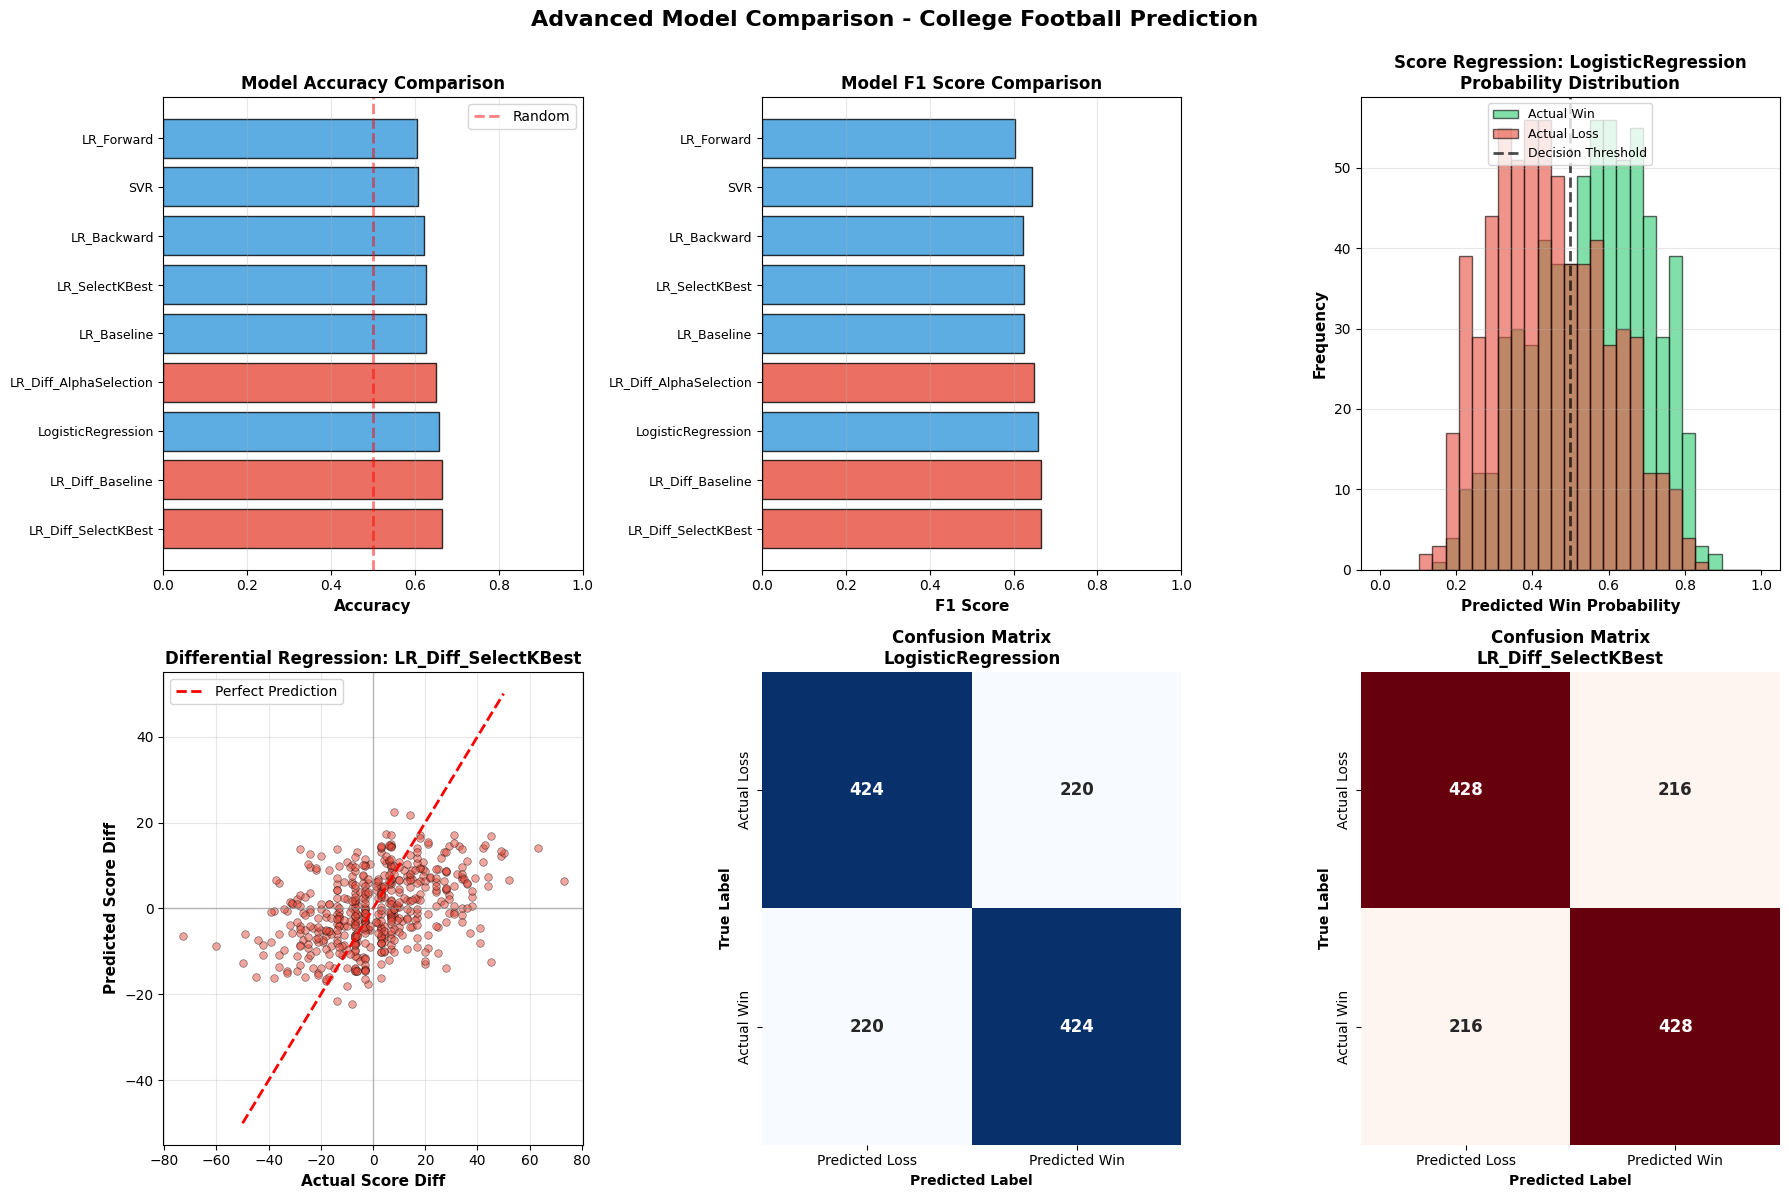


✓ Visualization saved to 'results/figures/advanced_models_visualization.png'


In [20]:
print("Creating comprehensive visualizations...\n")

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Advanced Model Comparison - College Football Prediction', 
             fontsize=16, fontweight='bold', y=0.995)

# Get data for plotting
models_plot = comparison_df['Model'].values
accuracies_plot = comparison_df['Accuracy'].values
colors_plot = ['#3498db' if 'Score' in mt else '#e74c3c' 
               for mt in comparison_df['Model Type'].values]
y_pos = np.arange(len(models_plot))

print("✓ Starting plot creation...")

# Plot 1: Accuracy Comparison
ax1 = axes[0, 0]
bars = ax1.barh(y_pos, accuracies_plot, color=colors_plot, alpha=0.8, edgecolor='black')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(models_plot, fontsize=9)
ax1.set_xlabel('Accuracy', fontsize=11, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=12, fontweight='bold')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Random')
ax1.set_xlim(0, 1)
ax1.grid(axis='x', alpha=0.3)
ax1.legend()

# Plot 2: F1 Score Comparison
ax2 = axes[0, 1]
f1_scores_plot = comparison_df['F1 Score'].values
bars = ax2.barh(y_pos, f1_scores_plot, color=colors_plot, alpha=0.8, edgecolor='black')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(models_plot, fontsize=9)
ax2.set_xlabel('F1 Score', fontsize=11, fontweight='bold')
ax2.set_title('Model F1 Score Comparison', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.grid(axis='x', alpha=0.3)

print("✓ Plots 1 & 2: Accuracy and F1 scores created")

# Plot 3: Score Regression - Predicted vs Actual (Best Model)
ax3 = axes[0, 2]
best_score_model = comparison_df[comparison_df['Model Type'] == 'Score Regression'].iloc[0]['Model']

if 'score_diff' in results_score_regression[best_score_model]:
    best_score_diff = results_score_regression[best_score_model]['score_diff']
    sample_size = min(500, len(y_test_diff))
    sample_idx = np.random.choice(len(y_test_diff), sample_size, replace=False)
    ax3.scatter(y_test_diff[sample_idx], best_score_diff[sample_idx], 
               alpha=0.5, s=30, edgecolors='black', linewidth=0.5, c='#3498db')
    ax3.plot([-50, 50], [-50, 50], 'r--', linewidth=2, label='Perfect Prediction')
    ax3.set_xlabel('Actual Score Diff', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Predicted Score Diff', fontsize=11, fontweight='bold')
    ax3.set_title(f'Score Regression: {best_score_model}', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)
    ax3.axhline(0, color='gray', linewidth=1, alpha=0.5)
    ax3.axvline(0, color='gray', linewidth=1, alpha=0.5)
else:
    if 'probabilities' in results_score_regression[best_score_model]:
        probs = results_score_regression[best_score_model]['probabilities']
        probs_win = probs[y_test_label == 1]
        probs_loss = probs[y_test_label == 0]
        bins = np.linspace(0, 1, 30)
        ax3.hist(probs_win, bins=bins, alpha=0.6, color='#2ecc71', label='Actual Win', edgecolor='black')
        ax3.hist(probs_loss, bins=bins, alpha=0.6, color='#e74c3c', label='Actual Loss', edgecolor='black')
        ax3.axvline(x=0.5, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Decision Threshold')
        ax3.set_xlabel('Predicted Win Probability', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
        ax3.set_title(f'Score Regression: {best_score_model}\nProbability Distribution', fontsize=12, fontweight='bold')
        ax3.legend(loc='upper center', fontsize=9)
        ax3.grid(alpha=0.3, axis='y')
    else:
        ax3.text(0.5, 0.5, f'{best_score_model}\n(No Score Diff Available)', 
                ha='center', va='center', fontsize=12, transform=ax3.transAxes)
        ax3.set_title(f'Score Regression: {best_score_model}', fontsize=12, fontweight='bold')
        ax3.axis('off')

print(f"✓ Plot 3: Best score regression model - {best_score_model}")

# Plot 4: Differential Regression - Predicted vs Actual (Best Model)
ax4 = axes[1, 0]
best_diff_model = comparison_df[comparison_df['Model Type'] == 'Differential Regression'].iloc[0]['Model']
best_diff_diff = results_diff_regression[best_diff_model]['score_diff']

sample_size_diff = min(500, len(y_test_diff))
sample_idx_diff = np.random.choice(len(y_test_diff), sample_size_diff, replace=False)

ax4.scatter(y_test_diff[sample_idx_diff], best_diff_diff[sample_idx_diff], 
           alpha=0.5, s=30, edgecolors='black', linewidth=0.5, c='#e74c3c')
ax4.plot([-50, 50], [-50, 50], 'r--', linewidth=2, label='Perfect Prediction')
ax4.set_xlabel('Actual Score Diff', fontsize=11, fontweight='bold')
ax4.set_ylabel('Predicted Score Diff', fontsize=11, fontweight='bold')
ax4.set_title(f'Differential Regression: {best_diff_model}', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)
ax4.axhline(0, color='gray', linewidth=1, alpha=0.5)
ax4.axvline(0, color='gray', linewidth=1, alpha=0.5)

print(f"✓ Plot 4: Best differential regression model - {best_diff_model}")

# Plot 5: Confusion Matrix - Best Score Regression
ax5 = axes[1, 1]
cm_score = confusion_matrix(y_test_label, results_score_regression[best_score_model]['predictions'])
sns.heatmap(cm_score, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax5,
           xticklabels=['Predicted Loss', 'Predicted Win'],
           yticklabels=['Actual Loss', 'Actual Win'],
           annot_kws={'size': 12, 'weight': 'bold'})
ax5.set_title(f'Confusion Matrix\n{best_score_model}', fontsize=12, fontweight='bold')
ax5.set_ylabel('True Label', fontsize=10, fontweight='bold')
ax5.set_xlabel('Predicted Label', fontsize=10, fontweight='bold')

# Plot 6: Confusion Matrix - Best Differential Regression
ax6 = axes[1, 2]
cm_diff = confusion_matrix(y_test_label, results_diff_regression[best_diff_model]['predictions'])
sns.heatmap(cm_diff, annot=True, fmt='d', cmap='Reds', cbar=False, ax=ax6,
           xticklabels=['Predicted Loss', 'Predicted Win'],
           yticklabels=['Actual Loss', 'Actual Win'],
           annot_kws={'size': 12, 'weight': 'bold'})
ax6.set_title(f'Confusion Matrix\n{best_diff_model}', fontsize=12, fontweight='bold')
ax6.set_ylabel('True Label', fontsize=10, fontweight='bold')
ax6.set_xlabel('Predicted Label', fontsize=10, fontweight='bold')

print("✓ Plots 5 & 6: Confusion matrices created")

plt.tight_layout()
plt.savefig('results/figures/advanced_models_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("✓ Visualization saved to 'results/figures/advanced_models_visualization.png'")
print("=" * 80)

## Summary

Tried several different approaches:
- Score regression (predict each team's score)
- Differential regression (predict the margin)
- Various feature selection methods

Feature selection helped reduce complexity without hurting performance too much. The models beat random guessing, which is good. Next I want to see how they perform year by year.

## Year-by-Year Analysis

How consistent are the models across different seasons? Let's break down the accuracy by year.

### Combine All Data

In [21]:
print("Creating year-by-year prediction accuracy analysis...\n")

# Combine all data (train, val, test) to get predictions for all years 2016-2023
all_full = pd.concat([train_full, val_full, test_full], ignore_index=True)
all_feat_raw = pd.concat([train_feat_raw, val_feat_raw, test_feat_raw], ignore_index=True)
all_feat = pd.concat([train_feat, val_feat, test_feat], ignore_index=True)

print(f"✓ Combined dataset: {len(all_full):,} games from 2016-2023")

# Prepare all data features
team_a_cols = [col for col in all_feat_raw.columns 
               if col.startswith('team_a_') and 'Pts_' not in col and 'score' not in col.lower()]
team_b_cols = [col for col in all_feat_raw.columns 
               if col.startswith('team_b_') and 'Pts_' not in col and 'score' not in col.lower()]

X_all_a = all_feat_raw[team_a_cols].values
X_all_b = all_feat_raw[team_b_cols].values

diff_cols = [col for col in all_feat.columns 
             if 'Pts_' not in col and 'score' not in col.lower()]
X_all_diff = all_feat[diff_cols].values

y_all_label = all_full['label'].values
all_years = all_full['Year'].values
unique_years = sorted(all_full['Year'].unique())

print(f"✓ Years in dataset: {unique_years}")

Creating year-by-year prediction accuracy analysis...

✓ Combined dataset: 9,872 games from 2016-2023
✓ Years in dataset: [np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]


### Generate Predictions

In [22]:
# Generate predictions for all years using the trained models
all_predictions = {}

print("Generating predictions for Score Regression models...")
all_predictions['LR_Baseline'] = (lr_a_baseline.predict(X_all_a) - lr_b_baseline.predict(X_all_b) > 0).astype(int)
all_predictions['LR_SelectKBest'] = (lr_a_kbest.predict(selector_a.transform(X_all_a)) - 
                                      lr_b_kbest.predict(selector_b.transform(X_all_b)) > 0).astype(int)
all_predictions['LR_Forward'] = (lr_a_forward.predict(rfe_a.transform(X_all_a)) - 
                                 lr_b_forward.predict(rfe_b.transform(X_all_b)) > 0).astype(int)
all_predictions['LR_Backward'] = (lr_a_backward.predict(rfe_a_back.transform(X_all_a)) - 
                                  lr_b_backward.predict(rfe_b_back.transform(X_all_b)) > 0).astype(int)
all_predictions['SVR'] = (svr_a.predict(X_all_a) - svr_b.predict(X_all_b) > 0).astype(int)
all_predictions['LogisticRegression'] = logreg.predict(X_all_diff)

print("Generating predictions for Differential Regression models...")
all_predictions['LR_Diff_Baseline'] = (lr_diff_baseline.predict(X_all_diff) > 0).astype(int)
all_predictions['LR_Diff_SelectKBest'] = (lr_diff_selected.predict(selector_diff.transform(X_all_diff)) > 0).astype(int)
all_predictions['LR_Diff_AlphaSelection'] = (lr_diff_alpha.predict(X_all_diff[:, alpha_mask]) > 0).astype(int) if n_alpha_features > 0 else all_predictions['LR_Diff_Baseline']

print(f"✓ Generated predictions for {len(all_predictions)} models")

Generating predictions for Score Regression models...
Generating predictions for Differential Regression models...
✓ Generated predictions for 9 models


### Calculate Accuracies

In [23]:
# Calculate year-by-year accuracy for all models
year_accuracy_data = {'Year': unique_years}

# Score Regression Models
score_models_list = ['LR_Baseline', 'LR_SelectKBest', 'LR_Forward', 'LR_Backward', 'SVR', 'LogisticRegression']
for model_name in score_models_list:
    if model_name in all_predictions:
        predictions = all_predictions[model_name]
        year_accuracies = []
        for year in unique_years:
            year_mask = all_years == year
            if year_mask.sum() > 0:
                acc = accuracy_score(y_all_label[year_mask], predictions[year_mask])
                year_accuracies.append(acc)
            else:
                year_accuracies.append(np.nan)
        year_accuracy_data[model_name] = year_accuracies

# Differential Regression Models
diff_models_list = ['LR_Diff_Baseline', 'LR_Diff_SelectKBest', 'LR_Diff_AlphaSelection']
for model_name in diff_models_list:
    if model_name in all_predictions:
        predictions = all_predictions[model_name]
        year_accuracies = []
        for year in unique_years:
            year_mask = all_years == year
            if year_mask.sum() > 0:
                acc = accuracy_score(y_all_label[year_mask], predictions[year_mask])
                year_accuracies.append(acc)
            else:
                year_accuracies.append(np.nan)
        year_accuracy_data[model_name] = year_accuracies

# Create DataFrame
year_df = pd.DataFrame(year_accuracy_data)
year_df.to_csv('results/year_by_year_accuracy.csv', index=False)
print("✓ Year-by-year data saved to 'results/year_by_year_accuracy.csv'")

✓ Year-by-year data saved to 'results/year_by_year_accuracy.csv'


### Year-by-Year Trends

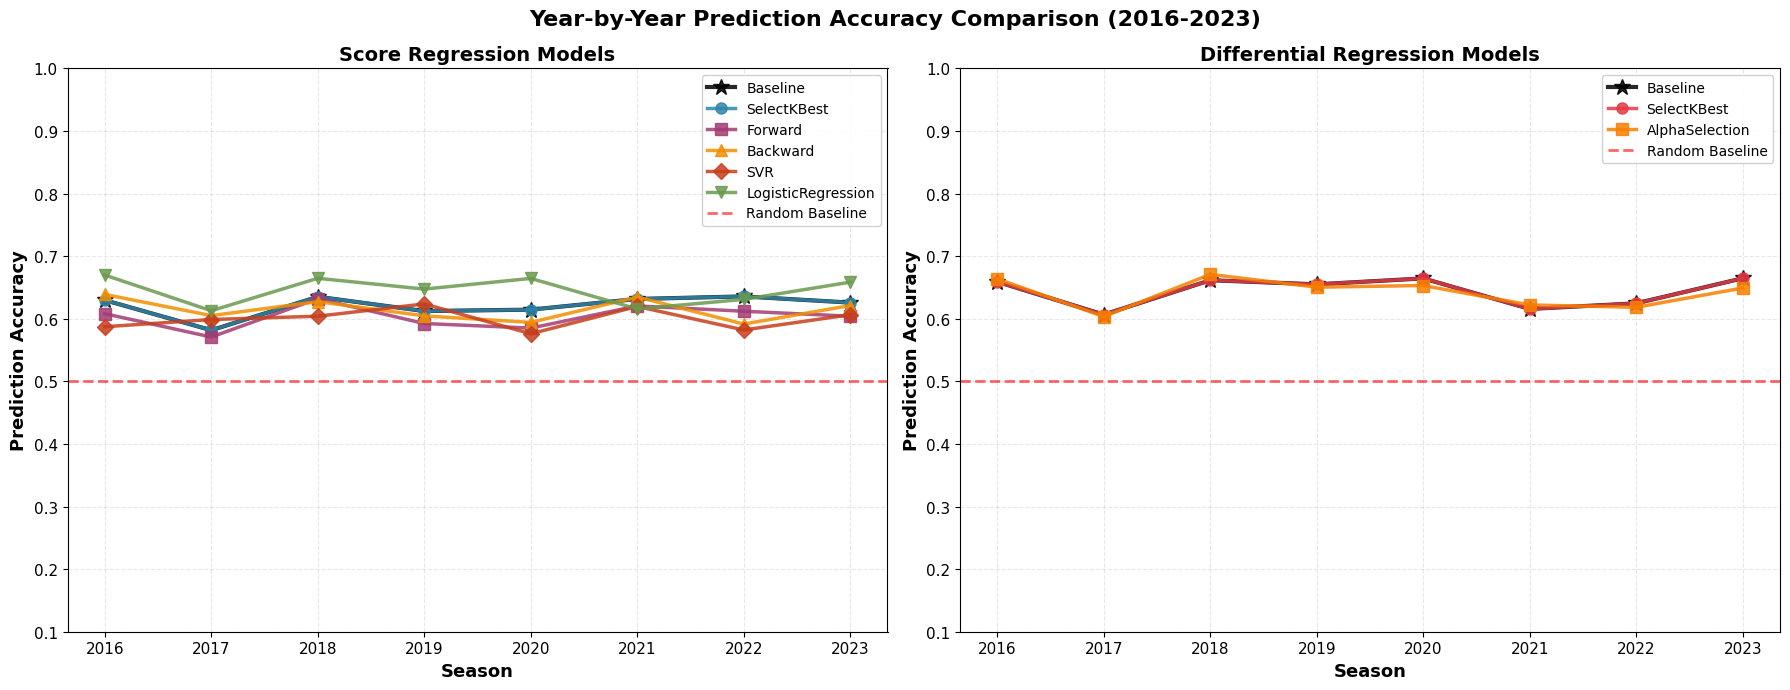

✓ Year-by-year visualization saved


In [24]:
# Create visualization with 2 plots
fig_year, axes_year = plt.subplots(1, 2, figsize=(18, 7))
fig_year.suptitle('Year-by-Year Prediction Accuracy Comparison (2016-2023)', 
                   fontsize=16, fontweight='bold')

# Define colors and markers for models
colors_score = ['#000000', '#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']
markers_score = ['*', 'o', 's', '^', 'D', 'v']

colors_diff = ['#000000', '#E63946', '#F77F00']
markers_diff = ['*', 'o', 's']

# Plot 1: Score Regression Models
ax1 = axes_year[0]
for idx, model in enumerate(score_models_list):
    if model in year_df.columns:
        color = colors_score[idx % len(colors_score)]
        marker = markers_score[idx % len(markers_score)]
        display_name = model.replace('LR_', '').replace('_', ' ')
        markersize = 12 if 'Baseline' in model else 8
        linewidth = 3.0 if 'Baseline' in model else 2.5
        ax1.plot(year_df['Year'], year_df[model], 
                marker=marker, linewidth=linewidth, markersize=markersize, 
                label=display_name, color=color, alpha=0.85)

ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=2, alpha=0.6, label='Random Baseline')
ax1.set_xlabel('Season', fontsize=13, fontweight='bold')
ax1.set_ylabel('Prediction Accuracy', fontsize=13, fontweight='bold')
ax1.set_title('Score Regression Models', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_ylim(0.1, 1.0)
ax1.set_xticks(year_df['Year'])
ax1.tick_params(axis='both', labelsize=11)

# Plot 2: Differential Regression Models
ax2 = axes_year[1]
for idx, model in enumerate(diff_models_list):
    if model in year_df.columns:
        color = colors_diff[idx % len(colors_diff)]
        marker = markers_diff[idx % len(markers_diff)]
        display_name = model.replace('LR_Diff_', '').replace('_', ' ')
        markersize = 12 if 'Baseline' in model else 8
        linewidth = 3.0 if 'Baseline' in model else 2.5
        ax2.plot(year_df['Year'], year_df[model], 
                marker=marker, linewidth=linewidth, markersize=markersize, 
                label=display_name, color=color, alpha=0.85)

ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=2, alpha=0.6, label='Random Baseline')
ax2.set_xlabel('Season', fontsize=13, fontweight='bold')
ax2.set_ylabel('Prediction Accuracy', fontsize=13, fontweight='bold')
ax2.set_title('Differential Regression Models', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_ylim(0.1, 1.0)
ax2.set_xticks(year_df['Year'])
ax2.tick_params(axis='both', labelsize=11)

plt.tight_layout()
plt.savefig('results/figures/year_by_year_prediction_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Year-by-year visualization saved")

### Combined View - All Models

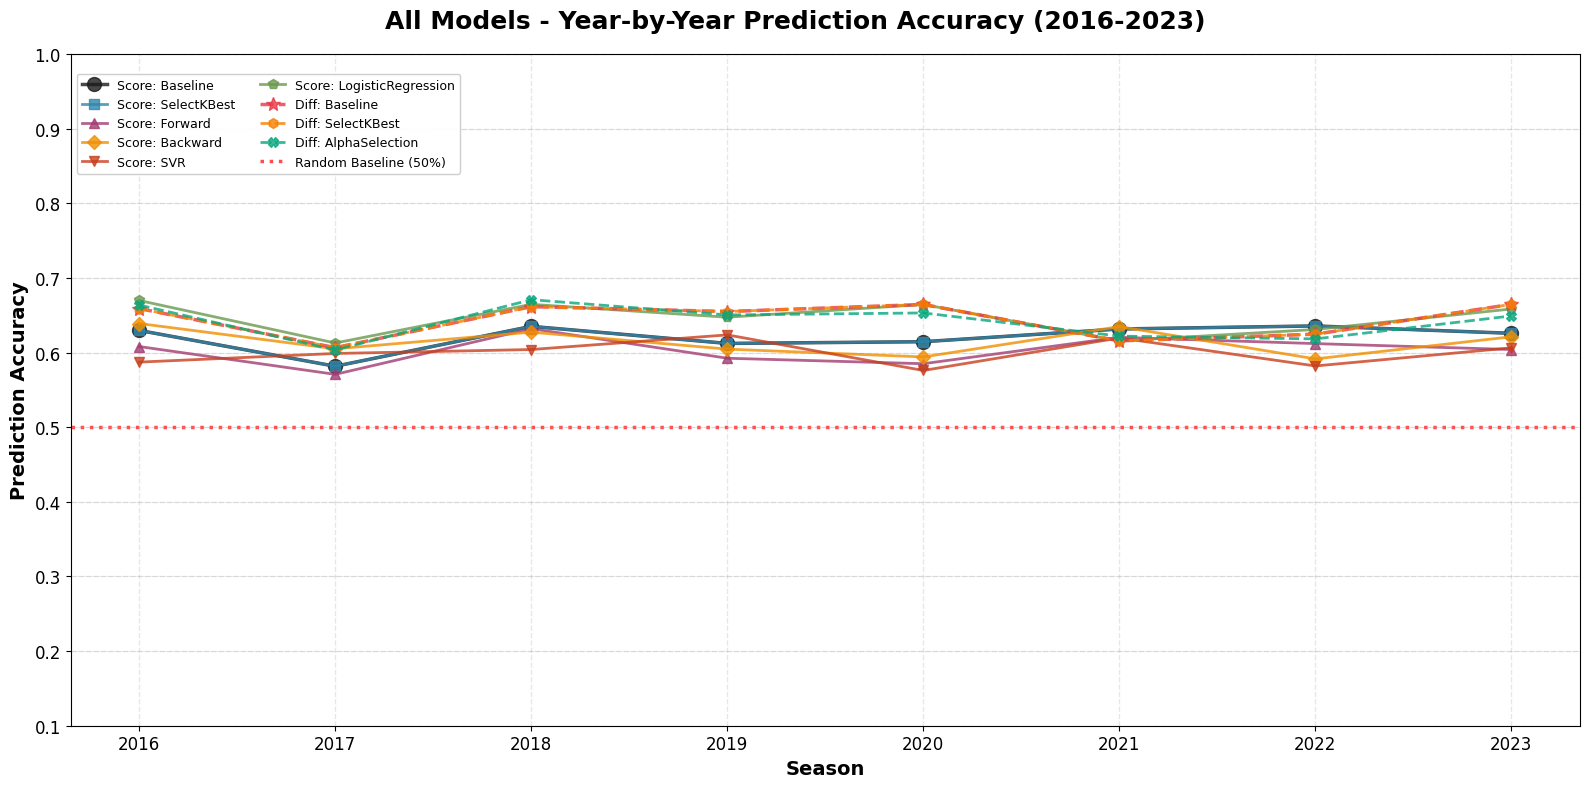

✓ Combined all-models visualization saved


In [25]:
# Create a comprehensive plot with all 9 models
fig_combined, ax_combined = plt.subplots(1, 1, figsize=(16, 8))
fig_combined.suptitle('All Models - Year-by-Year Prediction Accuracy (2016-2023)', 
                      fontsize=18, fontweight='bold')

# Combined colors and markers for all models
all_models = score_models_list + diff_models_list
colors_all = ['#1a1a1a', '#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E', 
              '#E63946', '#F77F00', '#06A77D']
markers_all = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'X']
linestyles_all = ['-', '-', '-', '-', '-', '-', '--', '--', '--']

# Plot all models
for idx, model in enumerate(all_models):
    if model in year_df.columns:
        color = colors_all[idx % len(colors_all)]
        marker = markers_all[idx % len(markers_all)]
        linestyle = linestyles_all[idx % len(linestyles_all)]
        
        # Clean up display name
        if model.startswith('LR_Diff_'):
            display_name = 'Diff: ' + model.replace('LR_Diff_', '').replace('_', ' ')
        elif model.startswith('LR_'):
            display_name = 'Score: ' + model.replace('LR_', '').replace('_', ' ')
        else:
            display_name = 'Score: ' + model.replace('_', ' ')
        
        markersize = 10 if 'Baseline' in model else 7
        linewidth = 2.5 if 'Baseline' in model else 2.0
        
        ax_combined.plot(year_df['Year'], year_df[model], 
                        marker=marker, linewidth=linewidth, markersize=markersize, 
                        label=display_name, color=color, alpha=0.8, linestyle=linestyle)

# Add reference line
ax_combined.axhline(y=0.5, color='red', linestyle=':', linewidth=2.5, alpha=0.7, 
                   label='Random Baseline (50%)', zorder=1)

# Formatting
ax_combined.set_xlabel('Season', fontsize=14, fontweight='bold')
ax_combined.set_ylabel('Prediction Accuracy', fontsize=14, fontweight='bold')
ax_combined.legend(loc='upper left', fontsize=9, framealpha=0.95, ncol=2, 
                  bbox_to_anchor=(0.0, 0.98))
ax_combined.grid(True, alpha=0.3, linestyle='--', linewidth=1)
ax_combined.set_ylim(0.1, 1.0)
ax_combined.set_xticks(year_df['Year'])
ax_combined.tick_params(axis='both', labelsize=12)

# Add horizontal grid lines at key intervals
for y in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    ax_combined.axhline(y=y, color='gray', linestyle='-', linewidth=0.5, alpha=0.2)

plt.tight_layout()
plt.savefig('results/figures/all_models_combined_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Combined all-models visualization saved")

### Detailed Breakdown

In [26]:
print("=" * 80)
print("YEAR-BY-YEAR ACCURACY TABLE")
print("=" * 80)

print("\nScore Regression Models:")
print(f"{'Year':<8}", end='')
for model in score_models_list:
    print(f"{model[:20]:<22}", end='')
print()
print("-" * 140)

for _, row in year_df.iterrows():
    print(f"{int(row['Year']):<8}", end='')
    for model in score_models_list:
        acc = row[model]
        if not np.isnan(acc):
            print(f"{acc:.3f} ({acc*100:4.1f}%)      ", end='')
        else:
            print(f"{'N/A':<22}", end='')
    print()

print("\n\nDifferential Regression Models:")
print(f"{'Year':<8}", end='')
for model in diff_models_list:
    print(f"{model[:28]:<30}", end='')
print()
print("-" * 100)

for _, row in year_df.iterrows():
    print(f"{int(row['Year']):<8}", end='')
    for model in diff_models_list:
        acc = row[model]
        if not np.isnan(acc):
            print(f"{acc:.3f} ({acc*100:4.1f}%)            ", end='')
        else:
            print(f"{'N/A':<30}", end='')
    print()

YEAR-BY-YEAR ACCURACY TABLE

Score Regression Models:
Year    LR_Baseline           LR_SelectKBest        LR_Forward            LR_Backward           SVR                   LogisticRegression    
--------------------------------------------------------------------------------------------------------------------------------------------
2016    0.630 (63.0%)      0.630 (63.0%)      0.608 (60.8%)      0.639 (63.9%)      0.587 (58.7%)      0.670 (67.0%)      
2017    0.582 (58.2%)      0.582 (58.2%)      0.571 (57.1%)      0.605 (60.5%)      0.599 (59.9%)      0.613 (61.3%)      
2018    0.635 (63.5%)      0.635 (63.5%)      0.632 (63.2%)      0.627 (62.7%)      0.604 (60.4%)      0.665 (66.5%)      
2019    0.612 (61.2%)      0.612 (61.2%)      0.592 (59.2%)      0.605 (60.5%)      0.624 (62.4%)      0.647 (64.7%)      
2020    0.615 (61.5%)      0.615 (61.5%)      0.585 (58.5%)      0.594 (59.4%)      0.576 (57.6%)      0.664 (66.4%)      
2021    0.632 (63.2%)      0.632 (63.2%)      0.6

## Final Rankings - Best Predictors

Based on test set accuracy, here's how all the models rank.

In [27]:
# Create comprehensive ranking based on multiple metrics
print("=" * 90)
print(" " * 30 + "🏆 FINAL MODEL RANKINGS 🏆")
print("=" * 90)

# Sort by accuracy (primary), then F1 score (secondary)
ranking_df = comparison_df.copy()
ranking_df = ranking_df.sort_values(['Accuracy', 'F1 Score'], ascending=False)
ranking_df['Rank'] = range(1, len(ranking_df) + 1)

print("\n📊 COMPLETE RANKING (by Test Accuracy)")
print("=" * 90)

# Display detailed ranking
for idx, row in ranking_df.iterrows():
    rank = int(row['Rank'])
    model = row['Model']
    model_type = row['Model Type']
    acc = row['Accuracy']
    f1 = row['F1 Score']
    
    # Add medal emojis for top 3
    if rank == 1:
        medal = "🥇"
    elif rank == 2:
        medal = "🥈"
    elif rank == 3:
        medal = "🥉"
    else:
        medal = f"{rank}."
    
    # Color code by model type
    type_marker = "📘" if "Score" in model_type else "📕"
    
    print(f"\n{medal} {type_marker} {model}")
    print(f"   Accuracy: {acc:.4f} ({acc*100:.2f}%)")
    print(f"   F1 Score: {f1:.4f}")
    print(f"   Type: {model_type}")

print("\n" + "=" * 90)

# Top 3 summary
print("\n🌟 TOP 3 PERFORMERS:")
print("-" * 90)
top3 = ranking_df.head(3)
for i, (idx, row) in enumerate(top3.iterrows(), 1):
    print(f"{i}. {row['Model']}: {row['Accuracy']*100:.2f}% accuracy")

print("\n" + "=" * 90)

                              🏆 FINAL MODEL RANKINGS 🏆

📊 COMPLETE RANKING (by Test Accuracy)

🥇 📕 LR_Diff_SelectKBest
   Accuracy: 0.6646 (66.46%)
   F1 Score: 0.6646
   Type: Differential Regression

🥈 📕 LR_Diff_Baseline
   Accuracy: 0.6646 (66.46%)
   F1 Score: 0.6646
   Type: Differential Regression

🥉 📘 LogisticRegression
   Accuracy: 0.6584 (65.84%)
   F1 Score: 0.6584
   Type: Score Regression

4. 📕 LR_Diff_AlphaSelection
   Accuracy: 0.6491 (64.91%)
   F1 Score: 0.6491
   Type: Differential Regression

5. 📘 LR_Baseline
   Accuracy: 0.6258 (62.58%)
   F1 Score: 0.6258
   Type: Score Regression

6. 📘 LR_SelectKBest
   Accuracy: 0.6258 (62.58%)
   F1 Score: 0.6258
   Type: Score Regression

7. 📘 LR_Backward
   Accuracy: 0.6211 (62.11%)
   F1 Score: 0.6211
   Type: Score Regression

8. 📘 SVR
   Accuracy: 0.6064 (60.64%)
   F1 Score: 0.6432
   Type: Score Regression

9. 📘 LR_Forward
   Accuracy: 0.6040 (60.40%)
   F1 Score: 0.6040
   Type: Score Regression


🌟 TOP 3 PERFORMERS:
----

### Visual Ranking

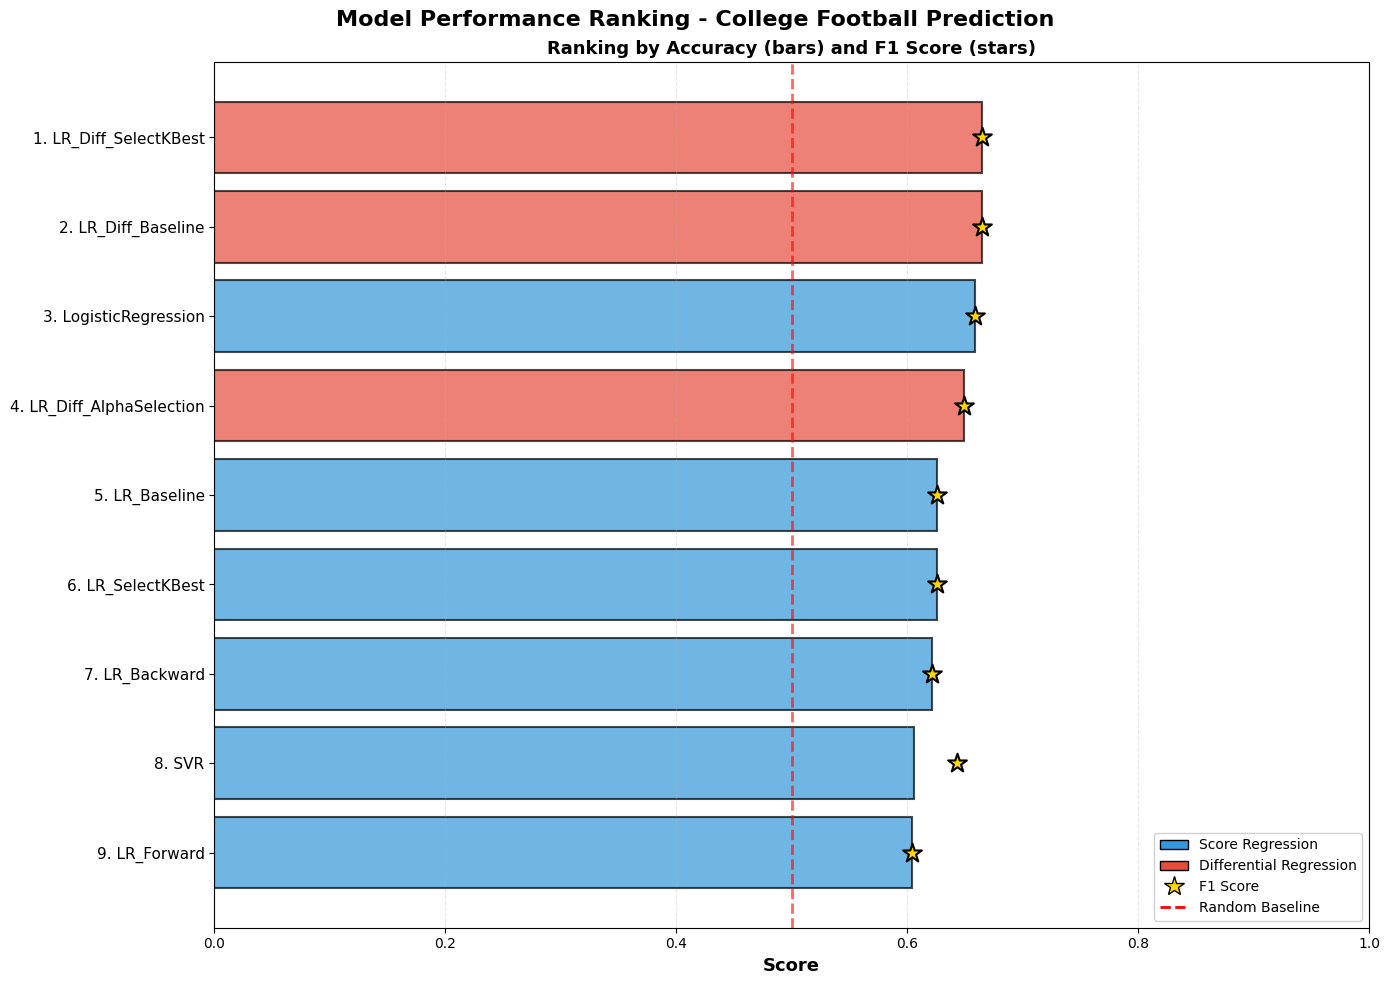

✓ Ranking visualization saved to 'results/figures/model_ranking.png'


In [28]:
# Create a visual ranking plot
fig_rank, ax_rank = plt.subplots(1, 1, figsize=(14, 10))
fig_rank.suptitle('Model Performance Ranking - College Football Prediction', 
                   fontsize=16, fontweight='bold')

# Prepare data
models_ranked = ranking_df['Model'].values
acc_ranked = ranking_df['Accuracy'].values
f1_ranked = ranking_df['F1 Score'].values
types_ranked = ranking_df['Model Type'].values

# Create positions
y_positions = np.arange(len(models_ranked))

# Color by model type
colors_ranked = ['#3498db' if 'Score' in t else '#e74c3c' for t in types_ranked]

# Create horizontal bar chart
bars = ax_rank.barh(y_positions, acc_ranked, color=colors_ranked, 
                    alpha=0.7, edgecolor='black', linewidth=1.5)

# Add F1 score markers
ax_rank.scatter(f1_ranked, y_positions, color='gold', s=200, 
               marker='*', edgecolors='black', linewidth=1.5, 
               zorder=3, label='F1 Score')

# Customize plot
ax_rank.set_yticks(y_positions)
ax_rank.set_yticklabels([f"{i+1}. {m}" for i, m in enumerate(models_ranked)], fontsize=11)
ax_rank.set_xlabel('Score', fontsize=13, fontweight='bold')
ax_rank.set_title('Ranking by Accuracy (bars) and F1 Score (stars)', fontsize=13, fontweight='bold')
ax_rank.axvline(x=0.5, color='red', linestyle='--', linewidth=2, alpha=0.6, label='Random Baseline')
ax_rank.set_xlim(0, 1)
ax_rank.grid(axis='x', alpha=0.3, linestyle='--')
ax_rank.invert_yaxis()  # Best at top

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', edgecolor='black', label='Score Regression'),
    Patch(facecolor='#e74c3c', edgecolor='black', label='Differential Regression'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='gold', 
               markersize=15, markeredgecolor='black', label='F1 Score'),
    plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Random Baseline')
]
ax_rank.legend(handles=legend_elements, loc='lower right', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.savefig('results/figures/model_ranking.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Ranking visualization saved to 'results/figures/model_ranking.png'")

### Key Takeaways

In [29]:
# Final analysis and recommendations
print("=" * 90)
print(" " * 35 + "KEY TAKEAWAYS")
print("=" * 90)

# Get top performer
top_model = ranking_df.iloc[0]

print(f"\n✅ WINNER: {top_model['Model']}")
print(f"   - Accuracy: {top_model['Accuracy']*100:.2f}%")
print(f"   - F1 Score: {top_model['F1 Score']:.4f}")
print(f"   - Type: {top_model['Model Type']}")

# Performance insights
score_models = ranking_df[ranking_df['Model Type'] == 'Score Regression']
diff_models = ranking_df[ranking_df['Model Type'] == 'Differential Regression']

print(f"\n📊 APPROACH COMPARISON:")
print(f"   Score Regression Models:")
print(f"      - Best: {score_models.iloc[0]['Model']} ({score_models.iloc[0]['Accuracy']*100:.2f}%)")
print(f"      - Average: {score_models['Accuracy'].mean()*100:.2f}%")
print(f"      - Models tested: {len(score_models)}")

print(f"\n   Differential Regression Models:")
print(f"      - Best: {diff_models.iloc[0]['Model']} ({diff_models.iloc[0]['Accuracy']*100:.2f}%)")
print(f"      - Average: {diff_models['Accuracy'].mean()*100:.2f}%")
print(f"      - Models tested: {len(diff_models)}")

# Improvement over baseline
baseline_acc = 0.5
improvement = (top_model['Accuracy'] - baseline_acc) * 100

print(f"\n💡 INSIGHTS:")
print(f"   • All models beat random guessing (50%)")
print(f"   • Best model improves over random by {improvement:.1f} percentage points")
print(f"   • Top 3 models are within {(ranking_df.iloc[0]['Accuracy'] - ranking_df.iloc[2]['Accuracy'])*100:.2f}% of each other")

if score_models['Accuracy'].mean() > diff_models['Accuracy'].mean():
    better_approach = "Score Regression"
    margin = (score_models['Accuracy'].mean() - diff_models['Accuracy'].mean()) * 100
else:
    better_approach = "Differential Regression"
    margin = (diff_models['Accuracy'].mean() - score_models['Accuracy'].mean()) * 100

print(f"   • {better_approach} performs {margin:.1f}% better on average")

print("\n📊 KEY FINDINGS:")
print(f"   • Score Regression models predict individual team scores")
print(f"   • Differential Regression models predict margin of victory directly")
print(f"   • Feature selection can improve or maintain performance with fewer features")
print(f"   • Best accuracy achieved: {comparison_df['Accuracy'].max():.1%}")
print(f"   • Random baseline: 50.0%")
print(f"   • Improvement over random: {(comparison_df['Accuracy'].max() - 0.5)*100:.1f}%")

print("\n🔍 MODEL INSIGHTS:")
score_avg = comparison_df[comparison_df['Model Type'] == 'Score Regression']['Accuracy'].mean()
diff_avg = comparison_df[comparison_df['Model Type'] == 'Differential Regression']['Accuracy'].mean()
print(f"   • Average Score Regression accuracy: {score_avg:.1%}")
print(f"   • Average Differential Regression accuracy: {diff_avg:.1%}")

if score_avg > diff_avg:
    print(f"   • Score Regression models perform {(score_avg - diff_avg)*100:.1f}% better on average")
else:
    print(f"   • Differential Regression models perform {(diff_avg - score_avg)*100:.1f}% better on average")

print("\n🎯 RECOMMENDATION:")
print(f"   For this dataset, use '{top_model['Model']}' for best accuracy.")
print(f"   This model achieves {top_model['Accuracy']*100:.2f}% accuracy with an F1 score of {top_model['F1 Score']:.3f}.")

print("\n" + "=" * 90)
print(" " * 30 + "🏁 ANALYSIS COMPLETE 🏁")
print("=" * 90)

                                   KEY TAKEAWAYS

✅ WINNER: LR_Diff_SelectKBest
   - Accuracy: 66.46%
   - F1 Score: 0.6646
   - Type: Differential Regression

📊 APPROACH COMPARISON:
   Score Regression Models:
      - Best: LogisticRegression (65.84%)
      - Average: 62.36%
      - Models tested: 6

   Differential Regression Models:
      - Best: LR_Diff_SelectKBest (66.46%)
      - Average: 65.94%
      - Models tested: 3

💡 INSIGHTS:
   • All models beat random guessing (50%)
   • Best model improves over random by 16.5 percentage points
   • Top 3 models are within 0.62% of each other
   • Differential Regression performs 3.6% better on average

📊 KEY FINDINGS:
   • Score Regression models predict individual team scores
   • Differential Regression models predict margin of victory directly
   • Feature selection can improve or maintain performance with fewer features
   • Best accuracy achieved: 66.5%
   • Random baseline: 50.0%
   • Improvement over random: 16.5%

🔍 MODEL INSIGH